# HJB Optimal Pairs Trading Strategy Visualization
This notebook computes and visualizes the optimal trading thresholds $(x_0, x_1, x_2)$ for a pairs trading model based on the Ornstein-Uhlenbeck process and the HJB equation.

It solves the quasi-variational inequalities using numerical methods, and plots the corresponding trading regions (Buy / Hold / Sell / Stop-loss).

In [3]:
import numpy as np
from scipy.special import gamma, pbdv
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [4]:
a, sigma, rho, K, b, M = 1.0, 0.56, 0.1, 0.001, 0, -0.2

# Why negative?
nu = rho / a
kappa = np.sqrt(2*a)/sigma

GAM = gamma(nu)

B1 = (a*b - rho*K)/(rho + a)
B2 = (a*b + rho*K)/(rho + a)

### Implementation notes

We have the following identity
$$
\int_0^{\infty} t^{\nu-1} e^{-\frac{1}{2} x^2-\mu t} d t= \Gamma(\nu) e^{\mu^2/4} D_{-\nu}\left(\mu\right), \quad \operatorname{Re} \nu>0
$$

So we have that
$$
\phi_1(x)=\int_0^{\infty} \eta(t) e^{-\kappa(b-x) t} d t = \int_0^{\infty} t^{\nu-1} e^{-t^2 / 2} e^{-\kappa(b-x) t} d t = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(\mu(x)\right)
$$
$$
\phi_2(x)=\int_0^{\infty} \eta(t) e^{\kappa(b-x) t} d t = \int_0^{\infty} t^{\nu-1} e^{-t^2 / 2} e^{\kappa(b-x) t} d t = \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-\nu}\left(-\mu(x)\right)
$$
where $\nu = \frac{\rho}{a}$ and $\mu(x) = \frac{\sqrt{2a}}{\sigma}(b-x)$.

By differentiating under the integral sign, we have that
$$
\phi_1'(x)=\kappa  \int_0^{\infty}  t^{\nu} e^{-t^2 / 2} e^{-\kappa(b-x) t} d t =  \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(\mu(x)\right)
$$
$$
\phi_2'(x)=-\kappa \int_0^{\infty} t^{\nu}  e^{-t^2 / 2}e^{\kappa(b-x) t} d t =  - \kappa \nu \Gamma(\nu) e^{\frac{\mu^2(x)}{4}} D_{-(\nu+1)}\left(-\mu(x)\right)
$$

In [5]:
def mu(x): return kappa * (b - x)

def phi1(x):
    Dv, _ = pbdv(-nu, mu(x))
    return GAM * np.exp(mu(x)**2 / 4.0) * Dv

def phi2(x):
    Dv, _ = pbdv(-nu, -mu(x))
    return GAM * np.exp(mu(x)**2 / 4.0) * Dv

def dphi1(x):
    Dv, _ = pbdv(-(nu+1), mu(x))
    return kappa * nu * GAM * np.exp(mu(x)**2 / 4.0) * Dv 

def dphi2(x):
    Dv, _ = pbdv(-(nu+1), -mu(x))
    return - kappa * nu * GAM * np.exp(mu(x)**2 / 4.0) * Dv 

def W(x): return phi1(x)*dphi2(x) - dphi1(x)*phi2(x)

def P1_up(x): return ((x+K)*dphi2(x) - phi2(x)) / W(x)
def P1_dn(x): return (phi1(x) - (x+K)*dphi1(x)) / W(x)
def P2_up(x): return ((x-K)*dphi2(x) - phi2(x)) / W(x)
def P2_dn(x): return (phi1(x) - (x-K)*dphi1(x)) / W(x)

'map_uvw_to_xs' maps unconstrained optimization variables $u, v, w \in \mathbb{R}$ into bounded regions for numerical stability.

We require that 
1. $M < x_1 \leq \frac{a b-\rho K}{\rho+a} = B_1$
2. $M<x_0<x_1$
3. $x_2>x_1, \frac{a b+\rho K}{\rho+a}$

In [9]:
def logistic(z): return 1.0 / (1.0 + np.exp(-z))
def softplus(z): return np.log1p(np.exp(z))

def map_uvw_to_xs(u, v, w, eps=1e-6):
    s1 = logistic(u)
    x1 = M + s1*(B1 - M)
    s0 = logistic(v)
    x0 = M + s0*(x1 - M)
    base = max(B2, x1) + eps
    x2 = base + softplus(w)
    return x0, x1, x2

def residuals_uvw(uvw):
    u, v, w = uvw
    x0, x1, x2 = map_uvw_to_xs(u, v, w)
    r1 = phi1(M)*P1_up(x0) + phi2(M)*P1_dn(x0) - (M - K)
    r2 = P1_up(x1) - P2_up(x2)
    r3 = P1_dn(x1) - P2_dn(x2)
    return np.array([r1, r2, r3], dtype=float)

In [15]:
uvw0 = np.array([0.0, -1.0, 0.0])
sol = least_squares(residuals_uvw, uvw0, method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=20000)
u_hat, v_hat, w_hat = sol.x
x0, x1, x2 = map_uvw_to_xs(u_hat, v_hat, w_hat)

print('Converged:', sol.success)
print(f'x0 = {x0:.6f}, x1 = {x1:.6f}, x2 = {x2:.6f}')

Converged: True
x0 = -0.141041, x1 = -0.075559, x2 = 0.075559


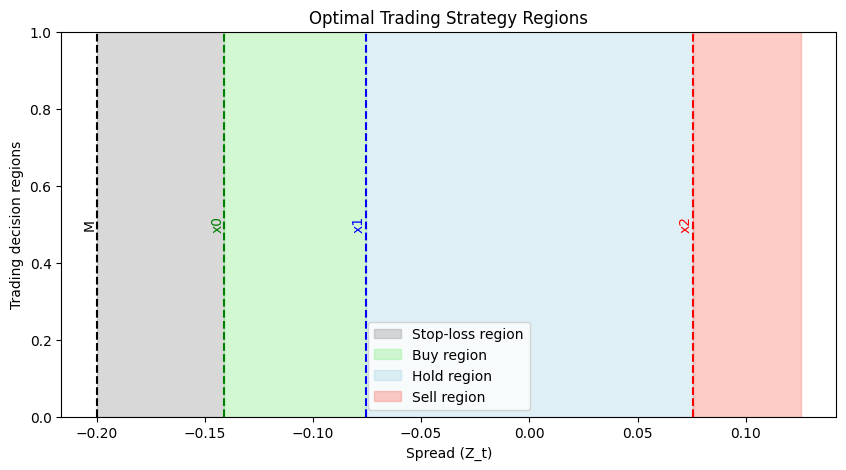

In [16]:
x_vals = np.linspace(M - 0.05, x2 + 0.05, 400)
fig, ax = plt.subplots(figsize=(10,5))
ax.axvspan(M, x0, color='gray', alpha=0.3, label='Stop-loss region')
ax.axvspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy region')
ax.axvspan(x1, x2, color='lightblue', alpha=0.4, label='Hold region')
ax.axvspan(x2, x2 + 0.05, color='salmon', alpha=0.4, label='Sell region')
for val, color, label in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axvline(val, color=color, linestyle='--')
    ax.text(val, 0.5, label, rotation=90, va='center', ha='right', color=color)
ax.set_xlabel('Spread (Z_t)')
ax.set_ylabel('Trading decision regions')
ax.set_title('Optimal Trading Strategy Regions')
ax.legend()
plt.show()

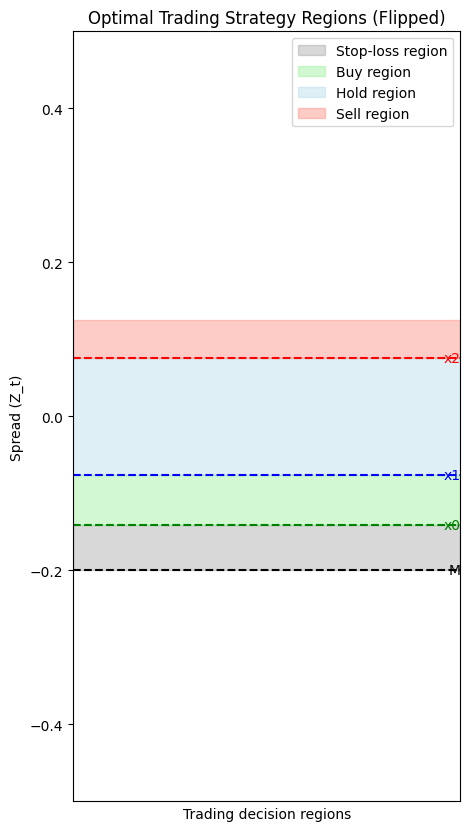

In [18]:
x_vals = np.linspace(M - 0.05, x2 + 0.05, 400)
fig, ax = plt.subplots(figsize=(5, 10))

# Horizontal spans (formerly vertical)
ax.axhspan(M, x0, color='gray', alpha=0.3, label='Stop-loss region')
ax.axhspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy region')
ax.axhspan(x1, x2, color='lightblue', alpha=0.4, label='Hold region')
ax.axhspan(x2, x2 + 0.05, color='salmon', alpha=0.4, label='Sell region')

# Horizontal lines and annotations (aligned to the right)
for val, color, label in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axhline(val, color=color, linestyle='--')
    ax.text(1.0, val, label, va='center', ha='right', color=color, transform=ax.get_yaxis_transform())

# Set limits and remove x ticks
ax.set_ylim(-0.5, 0.5)
ax.set_xticks([])

# Labels and layout
ax.set_ylabel('Spread (Z_t)')
ax.set_xlabel('Trading decision regions')
ax.set_title('Optimal Trading Strategy Regions (Flipped)')
ax.legend()

plt.show()


## Monte Carlo Simulation Validation
We simulate multiple Ornstein–Uhlenbeck paths and execute the trading rule defined by $(x_0, x_1, x_2, M)$ to estimate expected profit and variability.

In [ ]:

# --- Monte Carlo Simulation for Strategy Performance ---

def simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2,
                      n_paths=10000, n_steps=500, dt=1/52, seed=42):
    np.random.seed(seed)
    profits = []
    
    for _ in range(n_paths):
        Z = np.zeros(n_steps)
        Z[0] = 0  # start at equilibrium
        holding = False
        buy_price = 0.0
        total_profit = 0.0
        
        for t in range(1, n_steps):
            Z[t] = Z[t-1] + a*(b - Z[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
            
            if not holding and x0 < Z[t] < x1:
                holding = True
                buy_price = Z[t]
                total_profit -= K  # transaction cost
            
            elif holding:
                if Z[t] > x2:  # sell
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
                elif Z[t] < M:  # stop-loss
                    total_profit += (Z[t] - buy_price) - K
                    holding = False
        
        profits.append(total_profit)
    
    return np.mean(profits), np.std(profits)

mean_profit, std_profit = simulate_strategy(a, b, sigma, rho, K, M, x0, x1, x2)
print(f"Mean profit: {mean_profit:.4f}, Std: {std_profit:.4f}")


## 📘 Comparison: Paper vs Our Implementation

| Concept | In the Paper *(An Optimal Pairs-Trading Rule)* | In Our Notebook |
|----------|-----------------------------------------------|-----------------|
| **State variable** | Spread $Z_t$ follows Ornstein–Uhlenbeck process | Simulated OU process numerically |
| **Control decision** | Buy / Sell / Wait / Stop determined by HJB solution | Implemented via threshold $(M, x_0, x_1, x_2)$ |
| **Mathematical framework** | HJB quasi-variational inequality | Solved using numerical least-squares for boundary equations |
| **Key outputs** | Optimal thresholds $(x_0, x_1, x_2)$ | Computed explicitly in Python |
| **Validation** | Monte Carlo simulation (Section 5 of paper) | Performed with 10,000 simulated OU paths |
| **Visualization** | Conceptual trading regions diagram | Generated trading region chart + OU trajectories |

The notebook is thus a **computational reconstruction** of the theoretical model in the paper,
bridging abstract HJB mathematics and practical algorithmic trading simulation.


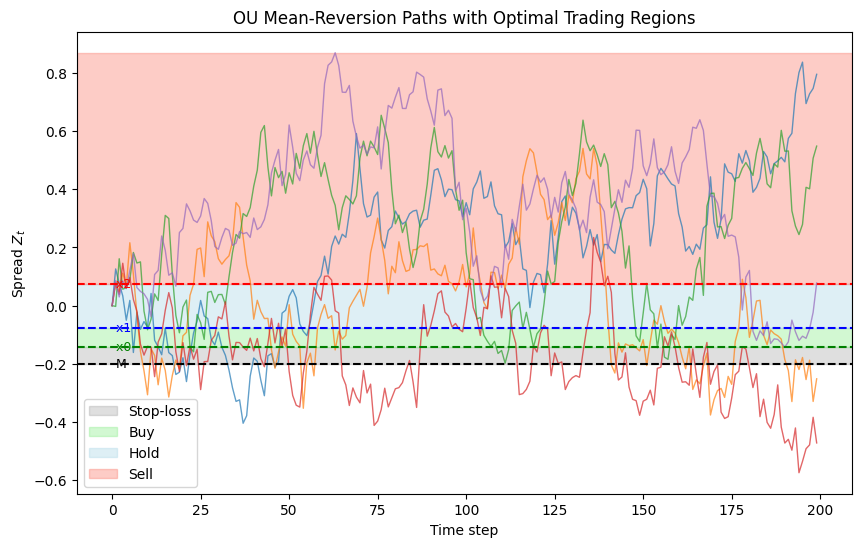

In [19]:

# --- Combined Visualization: OU Mean Reversion + Trading Strategy + Simulation Outcomes ---
import matplotlib.pyplot as plt

# Simulate a few OU paths for illustration
np.random.seed(1)
n_paths = 5
n_steps = 200
dt = 1/52
Z = np.zeros((n_paths, n_steps))
for i in range(n_paths):
    for t in range(1, n_steps):
        Z[i, t] = Z[i, t-1] + a*(b - Z[i, t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()

# Plot
fig, ax = plt.subplots(figsize=(10,6))
for i in range(n_paths):
    ax.plot(Z[i, :], lw=1, alpha=0.7)

# Draw regions
ax.axhspan(M, x0, color='gray', alpha=0.25, label='Stop-loss')
ax.axhspan(x0, x1, color='lightgreen', alpha=0.4, label='Buy')
ax.axhspan(x1, x2, color='lightblue', alpha=0.4, label='Hold')
ax.axhspan(x2, max(Z.max(), x2+0.05), color='salmon', alpha=0.4, label='Sell')

# Boundaries
for val, col, label in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axhline(val, color=col, linestyle='--')
    ax.text(0, val, f' {label}', va='center', color=col, fontsize=9)

ax.set_xlabel('Time step')
ax.set_ylabel('Spread $Z_t$')
ax.set_title('OU Mean-Reversion Paths with Optimal Trading Regions')
ax.legend()
plt.show()


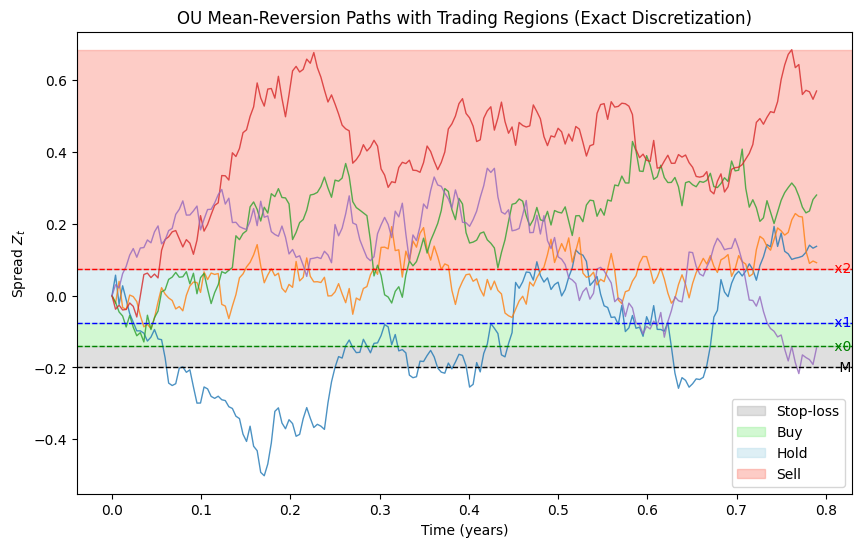

In [45]:
# Parameters assumed defined: a, b, sigma, M, x0, x1, x2
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
n_paths = 5
n_steps = 200
dt = 1/252

t = np.arange(n_steps) * dt
Z = np.empty((n_paths, n_steps))
Z[:, 0] = b  # start at long-run mean (optional; use your preferred initial)

exp_adt = np.exp(-a * dt)
sigma_hat = sigma * np.sqrt((1 - np.exp(-2*a*dt)) / (2*a))

# Vectorized simulation (exact discretization)
for k in range(1, n_steps):
    eps = np.random.randn(n_paths)
    Z[:, k] = b + (Z[:, k-1] - b) * exp_adt + sigma_hat * eps

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(n_paths):
    ax.plot(t, Z[i], lw=1, alpha=0.8)

# Regions (ensure correct ordering)
ax.axhspan(min(M, x0), max(M, x0), color='gray', alpha=0.25, label='Stop-loss', zorder=0)
ax.axhspan(min(x0, x1), max(x0, x1), color='lightgreen', alpha=0.4, label='Buy', zorder=0)
ax.axhspan(min(x1, x2), max(x1, x2), color='lightblue', alpha=0.4, label='Hold', zorder=0)

ymax_sell = max(Z.max(), x2 + 0.05)
ax.axhspan(min(x2, ymax_sell), max(x2, ymax_sell), color='salmon', alpha=0.4, label='Sell', zorder=0)

# Boundaries + right-side annotations
for val, col, lab in [(M, 'black', 'M'), (x0, 'green', 'x0'), (x1, 'blue', 'x1'), (x2, 'red', 'x2')]:
    ax.axhline(val, color=col, linestyle='--', lw=1.0)
    ax.text(1.0, val, f' {lab}', va='center', ha='right', color=col,
            transform=ax.get_yaxis_transform())

# Axes
ymin = min(Z.min(), M, x0, x1, x2) - 0.05
ymax = max(Z.max(), M, x0, x1, x2, x2 + 0.05) + 0.05
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Time (years)')
ax.set_ylabel(r'Spread $Z_t$')
ax.set_title('OU Mean-Reversion Paths with Trading Regions (Exact Discretization)')

# Clean legend (no duplicate entries)
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), frameon=True)

plt.show()
